D(St)reams of Anomalies
The real world does not slow down for bad data

1. Set up a data science project structure in a new git repository in your GitHub account
2. Download the benchmark data set from
https://www.kaggle.com/boltzmannbrain/nab or
https://github.com/numenta/NAB/tree/master/data
3. Load the one of the data set into panda data frames
4. Formulate one or two ideas on how feature engineering would help the data set to establish additional value using exploratory data analysis
5. Build one or more anomaly detection models to determine the anomalies using the other columns as features
6. Document your process and results
7. Commit your notebook, source code, visualizations and other supporting files to the git repository in GitHub

### Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

For this work, we chose the following data set:
    
- realKnownCause/ambient_temperature_system_failure.csv: The ambient temperature in an office setting.

In [2]:
# Reads a .csv as pandas dataframe.
df = pd.read_csv('ambient_temperature_system_failure.csv', sep=',', engine='python')
df.head()

,timestamp,value
0,2013-07-04 00:00:00,69.880835
1,2013-07-04 01:00:00,71.220227
2,2013-07-04 02:00:00,70.877805
3,2013-07-04 03:00:00,68.959400
4,2013-07-04 04:00:00,69.283551


Let's check for missing values. From the figure below, we see that there's no missing data.

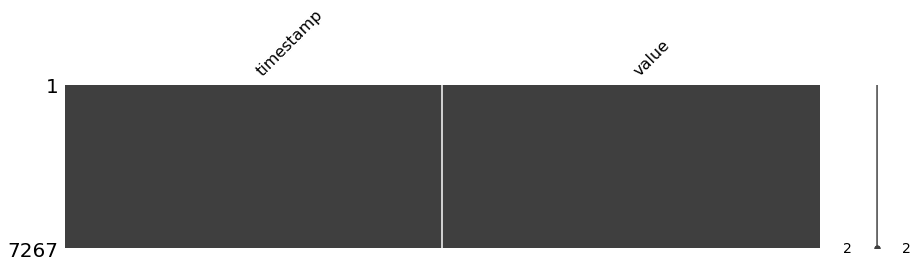

In [3]:
msno.matrix(df, figsize=(15, 3));

In [4]:
# Data types conversion.
df['timestamp'] = pd.to_datetime(df['timestamp'])

Now the data looks as expected:

In [5]:
df.dtypes

timestamp    datetime64[ns]
value               float64
dtype: object

### Features

First, let's take a quickly look into our data:

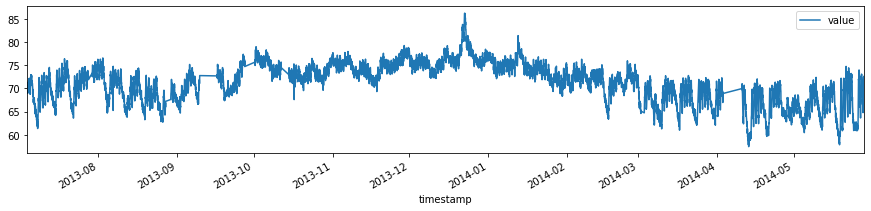

In [6]:
df.plot(x='timestamp', y='value', figsize=(15, 3));

From visual inspection we see that there is some seasonality in this data set. Since we are dealing with historical temperature in an office setting, this makes sense. We expect the temperature to rise in summer time and to decrease at night, for example. Let's create some features to investigate that:

In [7]:
df['month'] = df['timestamp'].dt.month
df['hour'] = df['timestamp'].dt.hour 
df['day_period'] = 'night'
df.loc[((df['hour'] >= 6) & (df['hour'] <= 12)), 'day_period'] = 'morning'
df.loc[((df['hour'] >= 13) & (df['hour'] <= 17)), 'day_period'] = 'afternoon'
df.loc[((df['hour'] >= 18) & (df['hour'] <= 21)), 'day_period'] = 'evening'

### Exploradory Data Analysis

In [8]:
df.columns

Index(['timestamp', 'value', 'month', 'hour', 'day_period'], dtype='object')

Let's check the distribution of the target value:

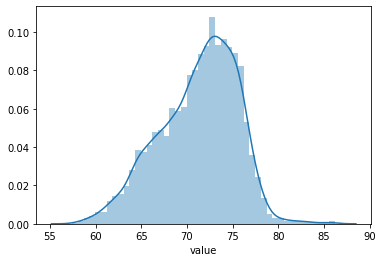

In [9]:
sns.distplot(df['value']);

From the graph above, we see that it's resemble a normal distribution.
Let's check how the features related to the target variable:

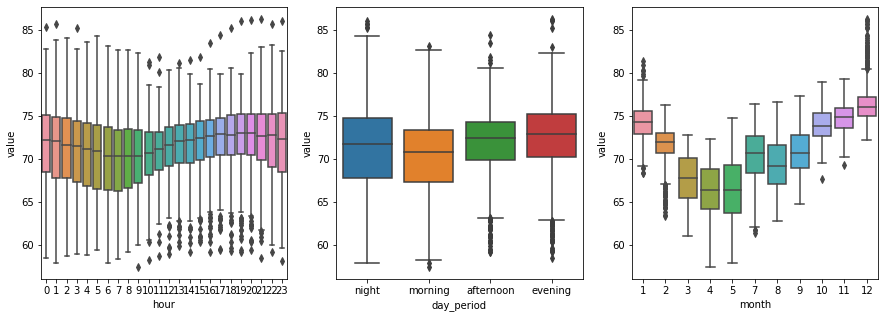

In [10]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
sns.boxplot(x="hour", y="value", data=df, ax=ax[0])
sns.boxplot(x="day_period", y="value", data=df, ax=ax[1])
sns.boxplot(x="month", y="value", data=df, ax=ax[2]);

From the figures above, we see that there is a high variation in temperature according to the hour of the day. The temperature starts increasing in the morning. After 10 am, from the boxplots, we see that the variation is inferior to the one observed at night. Outliers are also observed. We also see that temperature start increasing in July, the beginning of summer, reaching it's peak in January. In December we can notice some outliers at even higher temperatures.

### Modeling

We are going to use two unsupervised modes to detect anomalies in this the data base.

In [11]:
X = df.drop('timestamp', axis=1)

In [12]:
X.columns

Index(['value', 'month', 'hour', 'day_period'], dtype='object')

In [13]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(X['day_period'])
X['day_period'] = le.transform(X['day_period'] )

#### Clustering

##### K-Means

A simple approach that we can use to detect outliers is through the K-Means method. Here, we are going to assing a cluster to each point in the data set. Firstly, it's necessary to choose the number of clusters. For this purpose, we can make use of the Elbow Method (https://en.wikipedia.org/wiki/Elbow_method_(clustering)).

In [14]:
from sklearn.cluster import KMeans

n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(X) for i in n_cluster]
scores = [kmeans[i].score(X) for i in range(len(kmeans))]

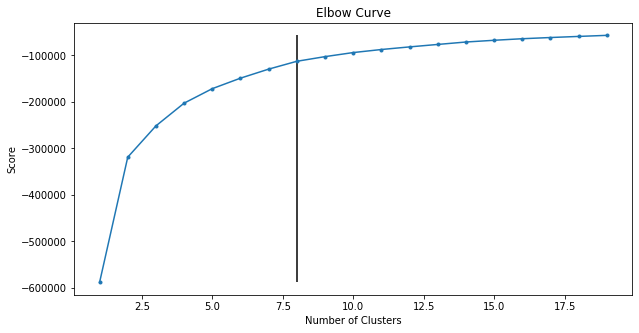

In [15]:
plt.figure(figsize=(10,5))
plt.plot(n_cluster, scores, marker='.')
plt.vlines(8, min(scores), max(scores))
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show();

In [16]:
kmeans = KMeans(n_clusters=8)
kmeans.fit(X)
cluster = kmeans.predict(X);

We have to generate a function to filter outliers. This is going to be done based on the distance of each point to the closest centroid. It's also necessary to define the % of expected outliers.

In [17]:
def getDistanceByPoint(df, model):
    distance = pd.Series()
    for i in range(0,len(df)):
        Xa = np.array(df.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.set_value(i, np.linalg.norm(Xa-Xb))
    return distance

outliers_fraction = 0.05
distance = getDistanceByPoint(X, kmeans)
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
df['anomaly'] = (distance >= threshold).astype(int)
df['cluster'] = cluster

/Users/paulaceccon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


In the following he have the detected outliers presented in orange. From visual inspection, this strategy seems to be performing poorly. As we can see, most of the outliers are grouped in the same date range.

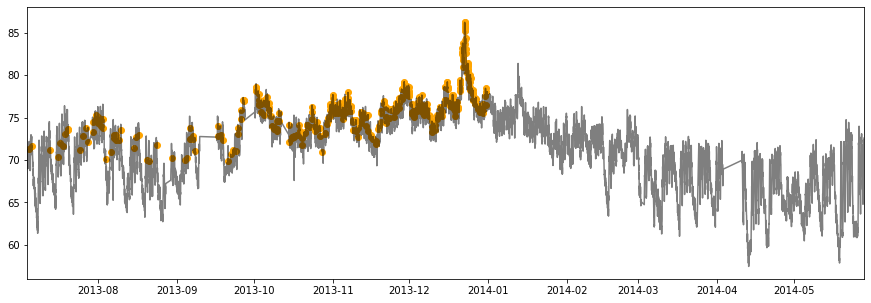

In [18]:
plt.figure(figsize=(15, 5))
plt.plot(df['timestamp'], df['value'], c='k', alpha=0.5)
plt.scatter(df[df['anomaly']==True]['timestamp'], df[df['anomaly']==True]['value'], c='orange')
plt.xlim((df['timestamp'].min(), df['timestamp'].max()));

The distribution of outliers shows that the majority of them occrus when the temperatue is within the range >- 70 <= 80. This is accordance with the previous plot showing the temperature variation by monht.

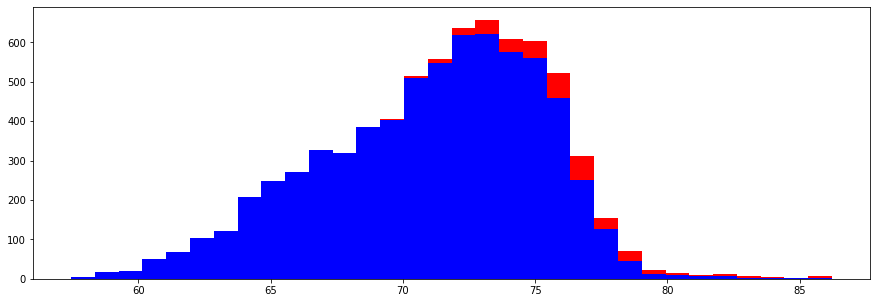

In [19]:
a = df.loc[df['anomaly'] != True, 'value']
b = df.loc[df['anomaly'] == True, 'value']

plt.figure(figsize=(15, 5))
plt.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly']);

##### DBSCAN

The next model that we are going to use is DBSCAN. This is a clustering algorithm (such as K-Means) that assing points to cluster and, unlike K-Means, identifies points no belonging to a cluster as outliers. Also, DBSCAN does not require the number of clusters to be specified in advance. However, the drawback is that we have to define the `eps` parameter, which will impact the % of the data being considered as outlier:

> `eps`: The maximum distance between two samples for one to be considered as in the neighborhood of the other. This is not a maximum bound on the distances of points within a cluster. This is the most important DBSCAN parameter to choose appropriately for your data set and distance function.

In [20]:
from sklearn.cluster import DBSCAN

model = DBSCAN(eps=1)
clusters = model.fit_predict(X)

In [21]:
df['cluster'] = clusters

The next plot shows the outliers in time as their distribution per temperature.

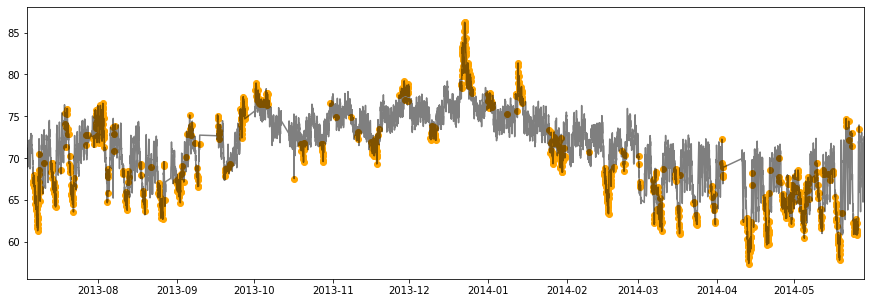

In [22]:
plt.figure(figsize=(15, 5))
plt.plot(df['timestamp'], df['value'], c='k', alpha=0.5)
plt.scatter(df[df['cluster']==-1]['timestamp'], df[df['cluster']==-1]['value'], c='orange')
plt.xlim((df['timestamp'].min(), df['timestamp'].max()));

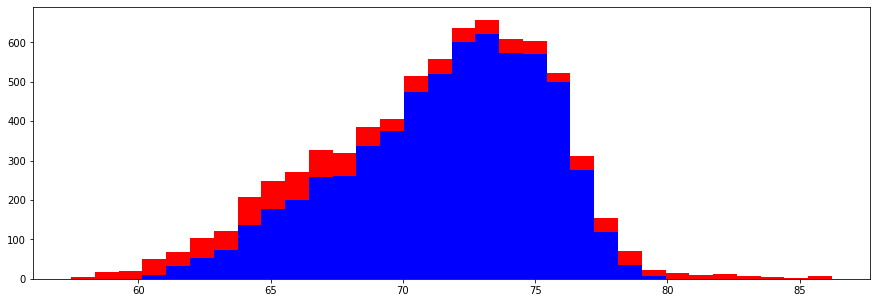

In [23]:
a = df.loc[df['cluster'] != -1, 'value']
b = df.loc[df['cluster'] == -1, 'value']

plt.figure(figsize=(15, 5))
plt.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly']);

As can be seen from the distribution plot, for lower temperatures we see a higher variation. We can also observe that extreme temperatures are considered as outliers.

#### Isolation Forest

The IsolationForest "isolates" observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature. The number of times you had to go through this step is the isolation number. The lower the number, the more anomalous the observation is. Here, it is necessary to specify a parameter called `contamination`, which defines the expect % of anomalies in the data.

In [24]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

model =  IsolationForest(contamination=0.05, behaviour='new')
model.fit(X)

df['anomaly'] = model.predict(X)

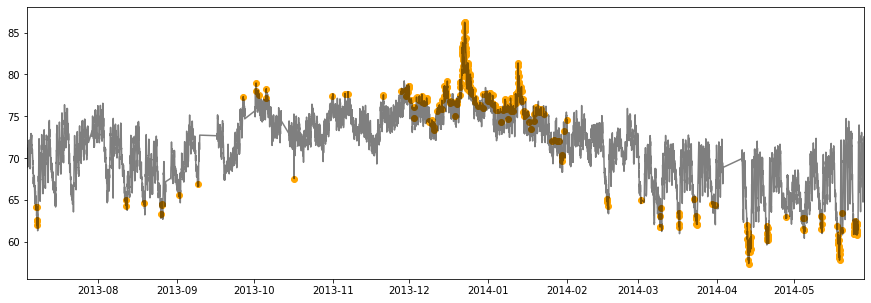

In [25]:
plt.figure(figsize=(15, 5))
plt.plot(df['timestamp'], df['value'], c='k', alpha=0.5)
plt.scatter(df[df['anomaly']==-1]['timestamp'], df[df['anomaly']==-1]['value'], c='orange')
plt.xlim((df['timestamp'].min(), df['timestamp'].max()));

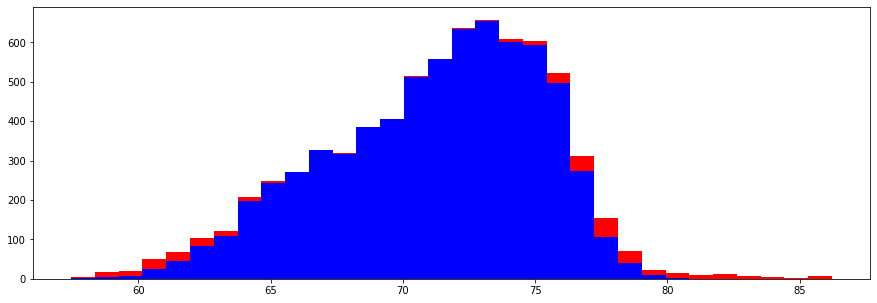

In [26]:
a = df.loc[df['anomaly'] != -1, 'value']
b = df.loc[df['anomaly'] == -1, 'value']

plt.figure(figsize=(15, 5))
plt.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly']);

Here, we see that extreme temperatures are also considered outliers. 